In [ ]:
# Install the pacakge if it hasn't been installed
%pip install pot

In [1]:
import numpy as np
import ot
#from scipy.stats import rdist
from sklearn.metrics import pairwise_distances
from math import pi
import multiprocess as mp
from scipy.stats import chi2
from scipy.stats import f
from scipy.stats import ortho_group
from scipy.stats import binom
from scipy.stats import halfnorm
from scipy.stats import norm
from datetime import datetime
NUM_CORE = 7
iter = 1000

# X, H: ndarray n by p
# Symmetry: Central, Sign, or Spherical
# Return the Wilcoxon_signed_rank statistic
def Wilcoxon_signed_rank(X, H, Symmetry="Central"):
    n, p = X.shape

    # define the cost function
    if Symmetry == "Central":
        def c_metric(x, h):
            return (-abs(np.inner(x, h)))

        def S(x, h):
            return (np.sign(np.inner(x, h)))

    if Symmetry == "Sign":
        def c_metric(x, h):
            return (-np.inner(abs(x), abs(h)))

        def S(x, h):
            return (np.sign(x * h))


    if Symmetry == "Spherical":
        x_norm = [np.linalg.norm(X[i,]) for i in range(n)]
        seq = sorted(x_norm)
        x_rank = [seq.index(v) for v in x_norm]
        h_norm = [np.linalg.norm(H[i,]) for i in range(n)]
        sorted_h = sorted(h_norm)
        W = sum([X[i,] * (sorted_h[x_rank[i]]/x_norm[i]) for i in range(n)])/np.sqrt(n)
        return (W)

    # loss matrix
    M = pairwise_distances(X, H, metric=c_metric, n_jobs=None)

    # Compute EMD
    G0 = ot.emd(np.ones((n,)), np.ones((n,)), M)

    W = sum([S(X[i,], H[next((i for i, x in enumerate(G0[i,]) if x > 0), None),]) * H[
        next((i for i, x in enumerate(G0[i,]) if x > 0), None),] for i in range(n)]) / np.sqrt(n)

    return (W)


def gram_schmidt(A):
    (n, m) = A.shape
    
    for i in range(m):
        
        q = A[:, i] # i-th column of A
        
        for j in range(i):
            q = q - np.dot(A[:, j], A[:, i]) * A[:, j]
        
        if np.array_equal(q, np.zeros(q.shape)):
            raise np.linalg.LinAlgError("The column vectors are not linearly independent")
        
        # normalize q
        q = q / np.sqrt(np.dot(q, q))
        
        # write the vector back in the matrix
        A[:, i] = q
    
    return (A)    
        
# X, H: ndarray n by p
# Symmetry: Central, Sign, or Spherical
# Return the p-value
def Wilcoxon_sign(X, H, gram_schmidt, Symmetry="Central"):
    n, p = X.shape

    # define the cost function
    if Symmetry == "Central":
        def c_metric(x, h):
            return (-abs(np.inner(x, h)))

        def S(x, h):
            return (np.sign(np.inner(x, h))*np.identity(p))

    if Symmetry == "Sign":
        def c_metric(x, h):
            return (-np.inner(abs(x), abs(h)))

        def S(x, h):
            return (np.diag(np.sign(x * h)))


    if Symmetry == "Spherical":
        x_norm = [np.linalg.norm(X[i,]) for i in range(n)]
        X = X[np.argsort(x_norm)]
        h_norm = [np.linalg.norm(H[i,]) for i in range(n)]
        H = H[np.argsort(h_norm)]
        Tn = 0
        for i in range(n):
            M1 = np.random.normal(loc=0.0, scale=1.0, size=(p, p))
            M1[0,:] = H[i,]
            M1 = gram_schmidt(M1)
            M2 = np.random.normal(loc=0.0, scale=1.0, size=(p, p))
            M2[0,:] = X[i,]
            M2 = gram_schmidt(M2).transpose()
            Tn = Tn + np.matmul(M1,M2)
        
        return (1 - chi2.cdf(np.sum(Tn*Tn)*p/n, df=p*p))
        

    # loss matrix
    M = pairwise_distances(X, H, metric=c_metric, n_jobs=None)

    # Compute EMD
    G0 = ot.emd(np.ones((n,)), np.ones((n,)), M)

    Tn = sum([S(X[i,], H[next((i for i, x in enumerate(G0[i,]) if x > 0), None),]) for i in range(n)])
    
    if Symmetry == "Central":
        return (1 - chi2.cdf(np.sum(Tn*Tn)/p/n, df=1))
    if Symmetry == "Sign":
        return (1 - chi2.cdf(np.sum(Tn*Tn)/n, df=p))
    
    return (W)

In [2]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
aids_clinical_trials_group_study_175 = fetch_ucirepo(id=890) 
  
# data (as pandas dataframes) 
X = aids_clinical_trials_group_study_175.data.features 
y = aids_clinical_trials_group_study_175.data.targets 
  
# metadata 
print(aids_clinical_trials_group_study_175.metadata) 
  
# variable information 
print(aids_clinical_trials_group_study_175.variables) 

{'uci_id': 890, 'name': 'AIDS Clinical Trials Group Study 175', 'repository_url': 'https://archive.ics.uci.edu/dataset/890/aids+clinical+trials+group+study+175', 'data_url': 'https://archive.ics.uci.edu/static/public/890/data.csv', 'abstract': 'The AIDS Clinical Trials Group Study 175 Dataset contains healthcare statistics and categorical information about patients who have been diagnosed with AIDS. This dataset was initially published in 1996. The prediction task is to predict whether or not each patient died within a certain window of time or not. ', 'area': 'Health and Medicine', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Tabular', 'Multivariate'], 'num_instances': 2139, 'num_features': 23, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Sexual Orientation', 'Race', 'Gender'], 'target_col': ['cid'], 'index_col': ['pidnum'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1996, 'last_updated': 'Fri Nov 

In [3]:
X.to_csv("aids_clinical_trials_X.csv", index=False)
y.to_csv("aids_clinical_trials_y.csv", index=False)

In [4]:
X

,time,trt,age,wtkg,hemo,homo,drugs,karnof,oprior,z30,...,gender,str2,strat,symptom,treat,offtrt,cd40,cd420,cd80,cd820
0,948,2,48,89.8128,0,0,0,100,0,0,...,0,0,1,0,1,0,422,477,566,324
1,1002,3,61,49.4424,0,0,0,90,0,1,...,0,1,3,0,1,0,162,218,392,564
2,961,3,45,88.4520,0,1,1,90,0,1,...,1,1,3,0,1,1,326,274,2063,1893
3,1166,3,47,85.2768,0,1,0,100,0,1,...,1,1,3,0,1,0,287,394,1590,966
4,1090,0,43,66.6792,0,1,0,100,0,1,...,1,1,3,0,0,0,504,353,870,782
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2134,1091,3,21,53.2980,1,0,0,100,0,1,...,1,1,3,0,1,1,152,109,561,720
2135,395,0,17,102.9672,1,0,0,100,0,1,...,1,1,3,0,0,1,373,218,1759,1030
2136,1104,2,53,69.8544,1,1,0,90,0,1,...,1,1,3,0,1,0,419,364,1391,1041
2137,465,0,14,60.0000,1,0,0,100,0,0,...,1,0,1,0,0,0,166,169,999,1838


In [5]:
selected_population = (X['trt'] == 0) & (X['cd40'] >= 200) & (X['cd40'] <= 500)
X0 = np.transpose(np.array([X.loc[selected_population, 'cd420'].values - X.loc[selected_population, 'cd40'].values, 
            X.loc[selected_population, 'cd820'].values - X.loc[selected_population, 'cd80'].values]))

In [6]:
print(np.mean(np.transpose(np.array([X.loc[selected_population, 'cd40'].values, 
            X.loc[selected_population, 'cd80'].values])),axis=0))
print(np.mean(np.transpose(np.array([X.loc[selected_population, 'cd420'].values, 
            X.loc[selected_population, 'cd820'].values])),axis=0))

[342.71559633 988.64220183]
[332.69266055 927.38302752]


In [7]:
n = X0.shape[0]
# central symmetry
from scipy.stats import norm, qmc, halfnorm

sampler = qmc.Halton(d=2,scramble=False)
U = sampler.random(n=n+1)[1:,:]
H = np.zeros((n,2))
H[:,1] = norm.ppf(U[:,1])
H[:,0] = halfnorm.ppf(U[:,0])

W = Wilcoxon_signed_rank(X0, H, Symmetry="Central")
# p-value
print(1 - chi2.cdf(np.inner(W, W), df=2))

# Hotelling's t2
mu = X0.mean(axis=0)
Sigma = np.cov(X0, rowvar=False)
# p-value
print(1 - chi2.cdf(n * np.inner(mu, np.linalg.solve(Sigma, mu)), df=2))

0.0002062856276325853
0.00028783537428744843


In [8]:
n

436

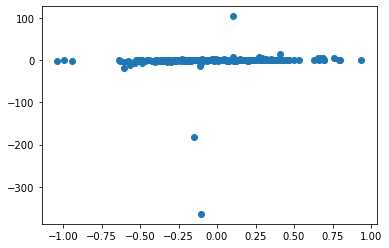

In [9]:
import matplotlib.pyplot as plt
from scipy.stats import norm, qmc, halfnorm, t
# Calculate the mean of each column
means = np.mean(X0, axis=0)

# Calculate the standard deviation of each column
std_devs = np.std(X0, axis=0)

# Normalize the columns
normalized_X0 = X0/ std_devs

normalized_X0 = t.ppf(norm.cdf(X0/500),df=1)
# Plotting
plt.scatter(normalized_X0[:,0], normalized_X0[:,1])
#plt.title("Scatter Plot of First Column Against Second Column")
#plt.xlabel("First Column")
#plt.ylabel("Second Column")
plt.show()

In [10]:
n = X0.shape[0]
# central symmetry

normalized_X0 = t.ppf(norm.cdf(X0/500),df=1)

sampler = qmc.Halton(d=2,scramble=False)
U = sampler.random(n=n+1)[1:,:]
H = np.zeros((n,2))
H[:,1] = norm.ppf(U[:,1])
H[:,0] = halfnorm.ppf(U[:,0])

W = Wilcoxon_signed_rank(normalized_X0, H, Symmetry="Central")
# p-value
print(1 - chi2.cdf(np.inner(W, W), df=2))

# Hotelling's t2
mu = normalized_X0.mean(axis=0)
Sigma = np.cov(normalized_X0, rowvar=False)
# p-value
print(1 - chi2.cdf(n * np.inner(mu, np.linalg.solve(Sigma, mu)), df=2))

0.00013982764337672204
0.057604805877908505


In [ ]:
# The Li-ion Battery Aging Data
# Data can be downloaded from https://www.kaggle.com/datasets/patrickfleith/nasa-battery-dataset?resource=download

In [2]:
import pandas as pd
metadata_df = pd.read_csv("/Users/huangzhen/Downloads/cleaned_dataset/metadata.csv")
from datetime import datetime
def string_to_datetime(time_str):
    # Clean the string: remove brackets and excess spaces
    clean_str = time_str.strip('[]').split()
    
    # Convert the clean string to a proper datetime format
    datetime_str = f"{int(float(clean_str[0]))}-{int(float(clean_str[1])):02d}-{int(float(clean_str[2])):02d} " \
                   f"{int(float(clean_str[3])):02d}:{int(float(clean_str[4])):02d}:{float(clean_str[5]):06.3f}"
    
    # Use pd.to_datetime to convert the formatted string to a datetime object
    return pd.to_datetime(datetime_str)
# Apply the conversion function to the DataFrame
metadata_df['start_time'] = metadata_df['start_time'].apply(string_to_datetime)
metadata_df

,type,start_time,ambient_temperature,battery_id,test_id,uid,filename,Capacity,Re,Rct
0,discharge,2010-07-21 15:00:35.093,4,B0047,0,1,00001.csv,1.6743047446975208,NaN,NaN
1,impedance,2010-07-21 16:53:45.968,24,B0047,1,2,00002.csv,NaN,0.05605783343888099,0.20097016584458333
2,charge,2010-07-21 17:25:40.671,4,B0047,2,3,00003.csv,NaN,NaN,NaN
3,impedance,2010-07-21 20:31:05.000,24,B0047,3,4,00004.csv,NaN,0.05319185850921101,0.16473399914864734
4,discharge,2010-07-21 21:02:56.984,4,B0047,4,5,00005.csv,1.5243662105099023,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
7560,impedance,2010-09-30 07:36:45.046,24,B0055,247,7561,07561.csv,NaN,0.0968087979207628,0.15489738203707232
7561,discharge,2010-09-30 08:08:36.328,4,B0055,248,7562,07562.csv,1.0201379996149256,NaN,NaN
7562,charge,2010-09-30 08:48:54.250,4,B0055,249,7563,07563.csv,NaN,NaN,NaN
7563,discharge,2010-09-30 11:50:17.687,4,B0055,250,7564,07564.csv,0.9907591663373165,NaN,NaN


In [3]:
metadata_df.loc[metadata_df["Capacity"]=="[]", "Capacity"] = np.nan
df1 = metadata_df[(metadata_df["battery_id"]=='B0005') & (metadata_df["type"]=="impedance")].copy()
df1["Rct"] = df1["Rct"].astype(float)
df1["Re"] = df1["Re"].astype(float)
df1["cycle"] = range(len(df1))

df2 = metadata_df[(metadata_df["battery_id"]=='B0007') & (metadata_df["type"]=="impedance")].copy()
df2["Rct"] = df2["Rct"].astype(float)
df2["Re"] = df2["Re"].astype(float)
df2["cycle"] = range(len(df2))

X0 = df1.loc[:,['Re','Rct']].iloc[140:275,:].values - df2.loc[:,['Re','Rct']].iloc[140:275,:].values

In [4]:
from scipy.stats import norm, qmc, halfnorm
n = X0.shape[0]
sampler = qmc.Halton(d=2,scramble=False)
np.random.seed(2024)
U = sampler.random(n=n+1)[1:,:]
H = np.zeros((n,2))
H[:,1] = norm.ppf(U[:,1])
H[:,0] = halfnorm.ppf(U[:,0])
W = Wilcoxon_signed_rank(X0, H, Symmetry="Central")
p_wilcox = 1 - chi2.cdf(np.inner(W, W), df=2)
            
# Hotelling's t2
mu = X0.mean(axis=0)
Sigma = np.cov(X0, rowvar=False)
p_T2 = 1 - chi2.cdf(n * np.inner(mu, np.linalg.solve(Sigma, mu)), df=2)
print(p_wilcox, p_T2)

0.023906061650486587 0.05860721625328358
